In [ ]:
import emcee
import numpy as np

import glob
import numpy as np
import matplotlib.pyplot as plt
import galsim
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
from os import path

from astropy.table import Table, vstack
from matplotlib.colors import SymLogNorm, LogNorm

import treecorr
import os
import scipy

from numpy import linalg
import matplotlib

import pickle
from scipy import stats
from psfmod import *
import seaborn as sns

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

#cmap = sns.color_palette("colorblind")

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plt.rcParams["font.family"] = "Times New Roman"
# matplotlib.rcParams['axes.linewidth'] = 2.0
cmap = sns.color_palette("colorblind")




In [3]:

def numerical_p_value(model):
    
    sample_size = 10000
    
    observe_dv = np.concatenate([model.gp_corr.reshape(-1), model.egal_mean])
    
    mean_dv = observe_dv[model.slice_]

    sample_data_vec = np.random.multivariate_normal( mean_dv , model.new_cov, size = sample_size )

    sample_diff = sample_data_vec - mean_dv
    

    chi2 = np.diag(sample_diff@ model.new_cov_inv @ sample_diff.T)
    
    index = chi2>model.chi2
    
    return np.sum(index)/sample_size
        


In [4]:
def likelihood_ratio(full_model, nest_model):
    LRT = 2 * ( (-full_model.chi2) - (-nest_model.chi2))
    return LRT

## You only need to run this once, it will measure the gp and pp correlations, and save it to the pickle file. 

In [5]:
fourth_model = psfmod("four", "data/covariance/covariance_psf.txt", constant_mode = True )
# fourth_model.go()
fourth_model.read_cov()
fourth_model.measure_correlation()

with open("data/correlation/full_correlation_psf.pkl", 'wb') as f:
    pickle.dump([fourth_model.r, fourth_model.gp_corr, fourth_model.pp_corr,  fourth_model.psf_const1, fourth_model.psf_const2, fourth_model.egal_mean ], f)
#     
    

## Model Fitting

In [6]:
def get_prior(chain):
    for i in range(chain.shape[-1]):
        print(np.mean(chain[:,i]), np.std(chain[:,i]))

In [7]:
theta_min = 1
theta_max = 200

In [9]:
second_model = psfmod("second", "data/covariance/covariance_psf.txt", constant_mode = False,
                      correlation_ready = True, correlation_file = "data/correlation/full_correlation_psf.pkl",
                      theta_min = theta_min, theta_max = theta_max)
second_model.go()

[-0.01385798 -1.82149681  0.          0.          0.          0.        ]


In [ ]:
print(second_model.mean_params)

print(second_model.chi2, second_model.p_value )
print()

In [12]:

# with open('/hildafs/projects/phy200017p/ztq1996/ztq1996/cosmosis/psf/run3-hsc-y3-mock/chain_support_files/pp_corr.pkl', 'wb') as f:
#     pickle.dump([second_model.r ,second_model.pp_corr,second_model.psf_const1, second_model.psf_const2], f)


In [13]:
second_const_model = psfmod("second", "data/covariance/covariance_psf.txt", constant_mode = True, correlation_ready = True,
                            correlation_file = "data/correlation/full_correlation_psf.pkl",
                                 theta_min = theta_min, theta_max = theta_max)
second_const_model.go()

[-9.72644748e-03 -1.64979450e+00  0.00000000e+00  0.00000000e+00
  5.36606181e-04  1.64626575e-04]


In [14]:
print(second_const_model.mean_params)

print(second_const_model.chi2, numerical_p_value(second_const_model),second_const_model.p_value )

[-9.75100026e-03 -1.64983365e+00 -1.44529368e-10 -1.08771208e-10
  5.36475797e-04  1.66255609e-04]
296.82656025598493 0.0 0.0


In [15]:
fourth_model = psfmod("four", "data/covariance/covariance_psf.txt", constant_mode = False , correlation_ready = True, 
                      correlation_file = "data/correlation/full_correlation_psf.pkl",
                     theta_min = theta_min, theta_max = theta_max)
fourth_model.go()

[ 0.03711074 -1.73445467  0.16943154 -0.9604186   0.          0.        ]


In [16]:
print(fourth_model.mean_params)

print(fourth_model.chi2, numerical_p_value(fourth_model),fourth_model.p_value )

[ 3.69929093e-02 -1.73590783e+00  1.69353104e-01 -9.60881640e-01
 -5.77616171e-11  2.33554789e-11]
60.74982405758638 0.9606 0.913109606800121


In [18]:
fourth_const_model = psfmod("four", "data/covariance/covariance_psf.txt", constant_mode = True , correlation_ready = True,
                            correlation_file = "data/correlation/full_correlation_psf.pkl",
                     theta_min = theta_min, theta_max = theta_max)
fourth_const_model.go()



[ 3.61262551e-02 -1.74297657e+00  1.69689023e-01 -1.01586479e+00
 -4.51058278e-05  2.05610572e-04]


In [19]:
print(fourth_const_model.mean_params)

print(fourth_const_model.chi2, numerical_p_value(fourth_const_model) , fourth_const_model.p_value)

[ 3.61078209e-02 -1.74397564e+00  1.69617315e-01 -1.01847552e+00
 -4.45446702e-05  2.07386937e-04]
58.69986495501242 0.975 0.9171622890973158


In [20]:
fourth_only_model = psfmod("fourth_only", "data/covariance/covariance_psf.txt", constant_mode = False , correlation_ready = True,
                           correlation_file = "data/correlation/full_correlation_psf.pkl",
                     theta_min = theta_min, theta_max = theta_max)
fourth_only_model.go()

[0.         0.         0.12088065 1.39429913 0.         0.        ]


In [21]:
print(fourth_only_model.mean_params)

print(fourth_only_model.chi2, numerical_p_value(fourth_only_model) , fourth_only_model.p_value)

[-9.33235722e-13 -6.45667651e-11  1.21063779e-01  1.39451764e+00
  8.31625545e-12 -5.49958083e-11]
512.914571100386 0.0 0.0


In [22]:
fourth_model = psfmod("four", "data/covariance/covariance_psf.txt", constant_mode = False , correlation_ready = True, 
                      correlation_file = "data/correlation/full_correlation_psf.pkl",
                     theta_min = theta_min, theta_max = theta_max)
fourth_model.go()




[ 0.03711074 -1.73445467  0.16943154 -0.9604186   0.          0.        ]


In [23]:
fitsecond_model = psfmod("second", "data/covariance/covariance_psf.txt", constant_mode = False,
                      correlation_ready = True, correlation_file = "data/correlation/full_correlation_psf.pkl",
                      theta_min = 1, theta_max = 200, fitsecond = True)
fitsecond_model.go()

[-0.01397918 -1.62004378  0.          0.          0.          0.        ]


In [24]:
get_prior(fitsecond_model.flatchain)

-0.013927223852008898 0.002635208947516294
-1.622799559221428 0.05735238640909982
1.1053035922051083e-10 5.763225548520068e-09
1.4766494071618525e-10 5.828439730699682e-09
1.0558497451396372e-10 5.729910350030037e-09
2.1957319051244564e-11 5.743433977315119e-09


In [26]:
# with open('../plots/pickle/psfmod_v2.pkl', 'wb') as f:
#     pickle.dump([second_model,second_const_model,fourth_model,fourth_const_model,fitsecond_model],f)

In [24]:
# with open('../plots/pickle/psfmod_v2.pkl', 'rb') as f:
#     second_model,second_const_model,fourth_model,fourth_const_model,fitsecond_model = pickle.load(f)

In [29]:
def show_pp_corr(r,pp_corr_xip):
    fig,ax = plt.subplots(1,3,figsize = (24,10))
    
    pp_corr_xip_err = np.zeros(pp_corr_xip.shape)
    
    plt.subplot(1,3,1)
    
    
    plt.plot(np.exp(r), pp_corr_xip[0][0], linewidth = 4,alpha = 0.8, color = cmap[0], label = '$<e_{psf} e_{psf}>$' )
    plt.plot(np.exp(r), pp_corr_xip[0][1], linewidth = 4,alpha = 0.8, color = cmap[1],label = '$<de_{psf} e_{psf}>$' )
    plt.plot(np.exp(r), pp_corr_xip[1][1],  linewidth = 4,alpha = 0.8,color = cmap[2],label = '$<de_{psf} de_{psf}>$')
    
    plt.plot(np.exp(r), -pp_corr_xip[0][0],'--', linewidth = 4,alpha = 0.8,color = cmap[0])
    plt.plot(np.exp(r), -pp_corr_xip[0][1],'--', linewidth = 4,alpha = 0.8,color = cmap[1]  )
    plt.plot(np.exp(r), -pp_corr_xip[1][1],'--', linewidth = 4,alpha = 0.8,color = cmap[2])

    plt.xscale('log')
    plt.yscale('log')
    plt.grid(linestyle = '--')
    plt.xlim([3,100])
    plt.ylim(2e-8,2e-3)
    plt.legend()
    plt.xlabel(r'$\theta$ (arcmin)')

    plt.subplot(1,3,2)

    plt.plot(np.exp(r), pp_corr_xip[2][0],linewidth = 4,alpha = 0.8,color = cmap[0], label = '$<e_{psf} M^{(4)}_{psf}>$')
    plt.plot(np.exp(r), pp_corr_xip[2][1],linewidth = 4,alpha = 0.8,color = cmap[1], label = '$<de_{psf} M^{(4)}_{psf}>$')
    plt.plot(np.exp(r), pp_corr_xip[2][2],linewidth = 4,alpha = 0.8,color = cmap[2], label = '$<M^{(4)}_{psf} M^{(4)}_{psf}>$')
    
    plt.plot(np.exp(r), -pp_corr_xip[2][0],'--',color = cmap[0],linewidth = 4,alpha = 0.8, )
    plt.plot(np.exp(r), -pp_corr_xip[2][1],'--',color = cmap[1],linewidth = 4,alpha = 0.8, )
    plt.plot(np.exp(r), -pp_corr_xip[2][2],'--',color = cmap[2],linewidth = 4,alpha = 0.8, )
    
    
    plt.xscale('log')
    plt.xlim([3,100])

    plt.yscale('log')
    plt.grid(linestyle = '--')
    plt.xlabel(r'$\theta$ (arcmin)')


    plt.legend()

    plt.subplot(1,3,3)

    plt.xlim([3,100])

    plt.plot(np.exp(r), pp_corr_xip[3][0],linewidth = 4,alpha = 0.8,color = cmap[0], label = '$<e_{psf} dM^{(4)}_{psf}>$')
    plt.plot(np.exp(r), pp_corr_xip[3][1],linewidth = 4,alpha = 0.8,color = cmap[1], label = '$<de_{psf} dM^{(4)}_{psf}>$')
    plt.plot(np.exp(r), pp_corr_xip[3][2],linewidth = 4,alpha = 0.8,color = cmap[2],label = '$< dM^{(4)}_{psf} dM^{(4)}_{psf}>$')
    plt.plot(np.exp(r), pp_corr_xip[3][3],linewidth = 4,alpha = 0.8,color = cmap[3], label = '$< dM^{(4)}_{psf} dM^{(4)}_{psf}>$')
    
    plt.plot(np.exp(r), -pp_corr_xip[3][0],'--',color = cmap[0],linewidth = 4,alpha = 0.8, )
    plt.plot(np.exp(r), -pp_corr_xip[3][1],'--',color = cmap[1],linewidth = 4,alpha = 0.8, )
    plt.plot(np.exp(r), -pp_corr_xip[3][2],'--',color = cmap[2],linewidth = 4,alpha = 0.8,)
    plt.plot(np.exp(r), -pp_corr_xip[3][3],'--',color = cmap[3],linewidth = 4,alpha = 0.8,)


    plt.xscale('log')
    plt.yscale('log')
    plt.grid(linestyle = '--')
    plt.xlabel(r'$\theta$ (arcmin)')


    plt.legend()



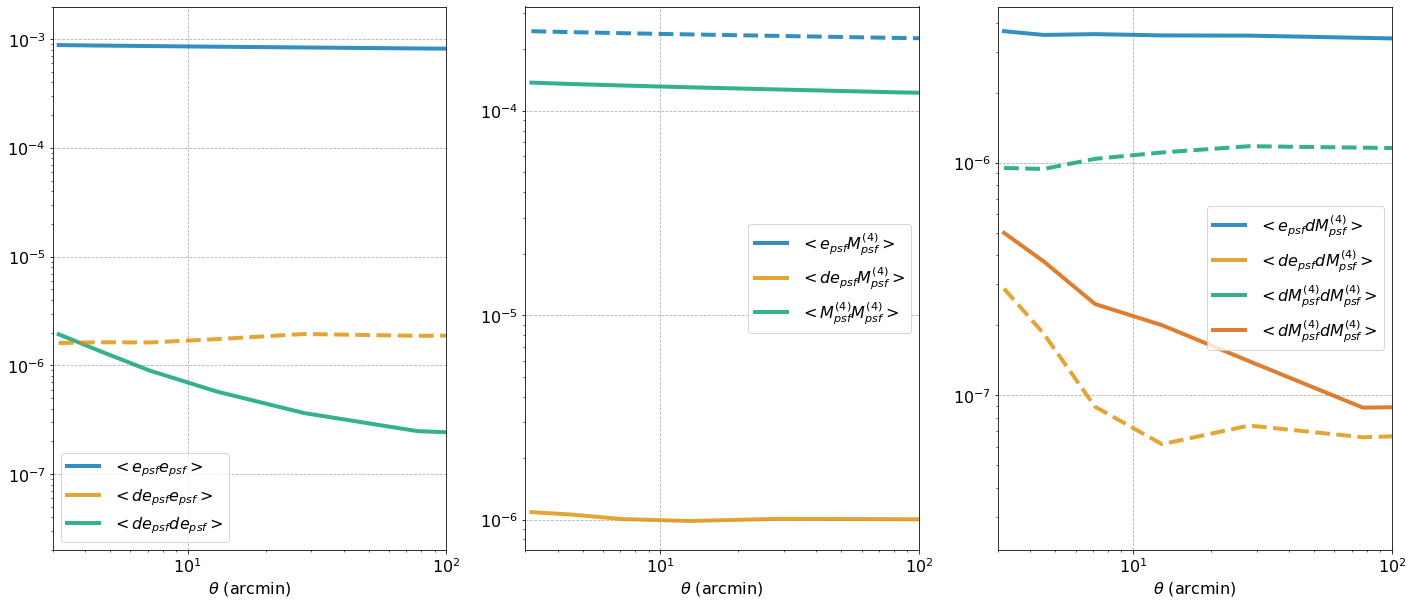

In [30]:
show_pp_corr(second_model.r, second_model.pp_corr)

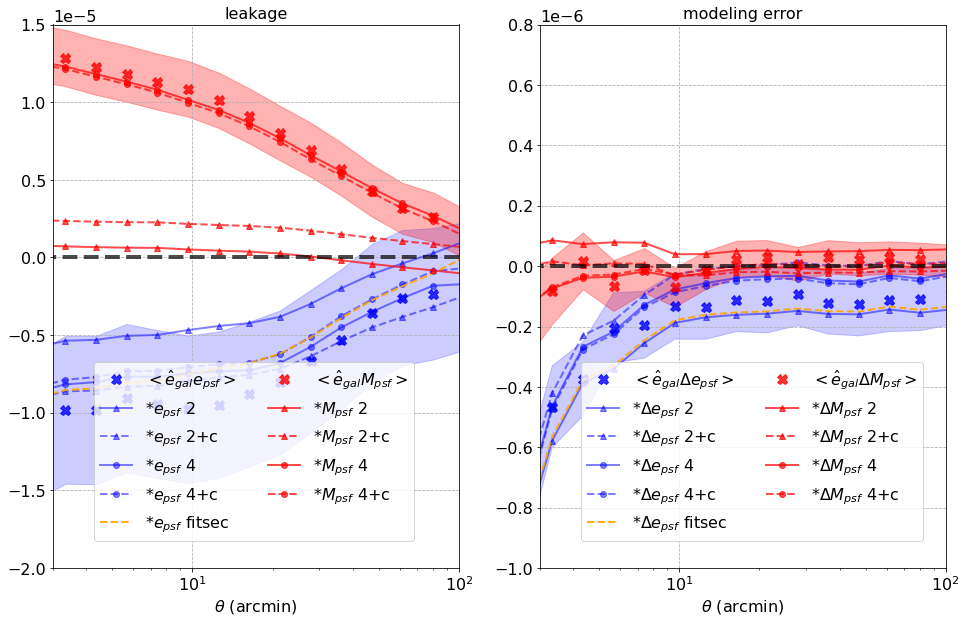

In [31]:

r = second_model.r

fig,ax = plt.subplots(1,2,figsize = (16,10))

plt.subplot(1,2,1)

gp0_err = np.sqrt(np.diag(fourth_model.cov)[:20])
gp2_err = np.sqrt(np.diag(fourth_model.cov)[40:60])

plt.plot(r , fourth_model.gp_corr[0], 'X',markersize = 10, linewidth = 4.0, alpha = 0.8, label = '$<\hat{e}_{gal} e_{psf}>$' , color = 'blue' )
plt.fill_between(r , fourth_model.gp_corr[0] - gp0_err,fourth_model.gp_corr[0] + gp0_err,color = 'blue' , alpha = 0.2)


plt.plot(r, second_model.bestfit_dv[0], '^-', linewidth = 2,alpha = 0.5,  label = '*$e_{psf}$ 2', color = 'blue')
plt.plot(r, second_const_model.bestfit_dv[0], '^--', linewidth = 2,alpha = 0.5,  label = '*$e_{psf}$ 2+c', color = 'blue')
plt.plot(r, fourth_model.bestfit_dv[0], 'o-', linewidth = 2,alpha = 0.5,  label = '*$e_{psf}$ 4', color = 'blue')
plt.plot(r, fourth_const_model.bestfit_dv[0], 'o--', linewidth = 2,alpha = 0.5,  label = '*$e_{psf}$ 4+c', color = 'blue')
plt.plot(r, fitsecond_model.bestfit_dv[0], '--', linewidth = 2,alpha = 0.9,  label = '*$e_{psf}$ fitsec', color = 'orange')


plt.plot(r, fourth_model.gp_corr[2], 'X',markersize = 10, linewidth = 4.0, alpha = 0.8, label = '$<\hat{e}_{gal} M_{psf}>$' , color = 'red')
plt.fill_between(fourth_model.r, fourth_model.gp_corr[2] - gp2_err,fourth_model.gp_corr[2] + gp2_err,color = 'red' , alpha = 0.3)


plt.plot(r, second_model.bestfit_dv[2], '^-', linewidth = 2,alpha = 0.7,  label = '*$M_{psf}$ 2', color = 'red')
plt.plot(r, second_const_model.bestfit_dv[2], '^--', linewidth = 2,alpha = 0.7,  label = '*$M_{psf}$ 2+c', color = 'red')
plt.plot(r, fourth_model.bestfit_dv[2], 'o-', linewidth = 2,alpha = 0.7,  label = '*$M_{psf}$ 4', color = 'red')
plt.plot(r, fourth_const_model.bestfit_dv[2], 'o--', linewidth = 2,alpha = 0.7,  label = '*$M_{psf}$ 4+c', color = 'red')




plt.plot([-1,400], [0,0], '--', color = 'black', linewidth = 4, alpha = 0.7)

plt.legend(loc = (0.1, 0.05), ncol = 2)
plt.grid(linestyle = '--')
plt.xlim([3,100])
plt.ylim([-2e-5, 1.5e-5])
# plt.fill_betweenx([-1,1], theta_min,theta_max,color = 'grey' , alpha = 0.2)

plt.title('leakage')

plt.xscale('log')
plt.xlabel(r'$\theta$ (arcmin)')




plt.subplot(1,2,2)


gp1_err = np.sqrt(np.diag(fourth_model.cov)[20:40])
gp3_err = np.sqrt(np.diag(fourth_model.cov)[60:80])


plt.plot(r , fourth_model.gp_corr[1], 'X',markersize = 10, linewidth = 4.0, alpha = 0.8, label = '$<\hat{e}_{gal} \Delta e_{psf}>$' , color = 'blue')
plt.fill_between(r , fourth_model.gp_corr[1] - gp1_err,fourth_model.gp_corr[1] + gp1_err,color = 'blue' , alpha = 0.2)

plt.plot(r, second_model.bestfit_dv[1], '^-', linewidth = 2,alpha = 0.5,  label = '*$\Delta e_{psf}$ 2', color = 'blue')
plt.plot(r, second_const_model.bestfit_dv[1], '^--', linewidth = 2,alpha = 0.5,  label = '*$\Delta e_{psf}$ 2+c', color = 'blue')
plt.plot(r, fourth_model.bestfit_dv[1], 'o-', linewidth = 2,alpha = 0.5,  label = '*$\Delta e_{psf}$ 4', color = 'blue')
plt.plot(r, fourth_const_model.bestfit_dv[1], 'o--', linewidth = 2,alpha = 0.5,  label = '*$\Delta e_{psf}$ 4+c', color = 'blue')
plt.plot(r, fitsecond_model.bestfit_dv[1], '--', linewidth = 2,alpha = 0.9,  label = '*$\Delta e_{psf}$ fitsec', color = 'orange')



plt.plot(r , fourth_model.gp_corr[3], 'X',markersize = 10, linewidth = 4.0, alpha = 0.8, label = '$<\hat{e}_{gal} \Delta M_{psf}>$' , color = 'red')
plt.fill_between(r, fourth_model.gp_corr[3] - gp3_err,fourth_model.gp_corr[3] + gp3_err,color = 'red' , alpha = 0.3)


plt.plot(r, second_model.bestfit_dv[3], '^-', linewidth = 2,alpha = 0.7,  label = '*$\Delta M_{psf}$ 2', color = 'red')
plt.plot(r, second_const_model.bestfit_dv[3], '^--', linewidth = 2,alpha = 0.7,  label = '*$\Delta M_{psf}$ 2+c', color = 'red')
plt.plot(r, fourth_model.bestfit_dv[3], 'o-', linewidth = 2,alpha = 0.7,  label = '*$\Delta M_{psf}$ 4', color = 'red')
plt.plot(r, fourth_const_model.bestfit_dv[3], 'o--', linewidth = 2,alpha = 0.7,  label = '*$\Delta M_{psf}$ 4+c', color = 'red')


plt.ylim(-1e-6, .8e-6)
# plt.fill_betweenx([-1,1], theta_min,theta_max,color = 'grey' , alpha = 0.2)

plt.xscale('log')
plt.grid(linestyle = '--')
plt.xlim([3,100])
plt.plot([-1,400], [0,0], '--', color = 'black', linewidth = 4, alpha = 0.7)

plt.title('modeling error')

plt.xlabel(r'$\theta$ (arcmin)')

plt.legend(loc = (0.1, 0.05), ncol = 2)

# plt.savefig('plots/bestfit6-60_nested_model.pdf', dpi = 100 )


In [32]:
def plot_contours(matrix, sigmas, fid, **kwargs):
    prefactor = {1:1.52, 2:2.48}
    prefactor = prefactor[sigmas]
    # matrix = np.linalg.inv(matrix)
    s00, s01, s11 = matrix[0][0], matrix[0][1], matrix[1][1]
    a = np.sqrt(
        0.5*(s00 + s11) + np.sqrt(s01**2 + 0.25*(s00-s11)**2)
    )
    b = np.sqrt(
        0.5*(s00 + s11) - np.sqrt(s01**2 + 0.25*(s00-s11)**2)
    )
    b *= prefactor
    a *= prefactor
    theta = np.arctan(2*s01/(s00-s11))/2
    eig = np.linalg.eig(matrix)
    maxeig = eig[1][np.argmax(eig[0])]
    theta = np.arctan2(maxeig[1], maxeig[0])
    el = matplotlib.patches.Ellipse(fid, 2*a, 2*b, angle=-np.degrees(theta), alpha=0.3, **kwargs)
    xlim = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    ylim = np.sqrt(a**2*np.sin(theta)**2 + b**2*np.cos(theta)**2)
    return el, xlim, ylim

In [33]:
covariance = second_model.cov
cov_const = covariance[80:, 80:]
egal_mean = fourth_const_model.egal_mean


In [34]:
egal_mean

array([-1.23263312e-04,  7.93654356e-05])

[-0.12326331  0.07936544]


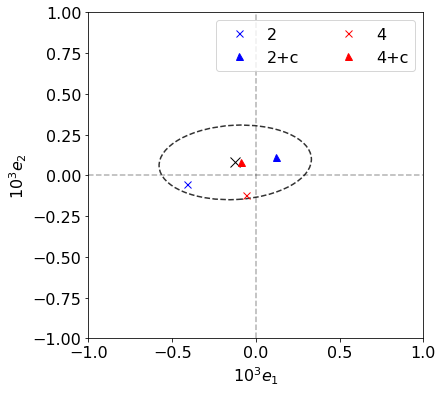

In [35]:
axes = plt.subplots(1,1, figsize = (6,6))



ax = plt.subplot(111)

covs = 1e6*cov_const
fid = 1000*np.array(egal_mean)
print(fid)

e, xlim, ylim = plot_contours(covs, 1, fid)
e.set_edgecolor('black')
e.set_linewidth(1.5)
e.set_facecolor('white')
e.set_linestyle('--')
plt.plot(fid[0] , fid[1] ,'x', markersize=10, color = 'black')


plt.plot(1000*second_model.bestfit_ec[0] , 1000*second_model.bestfit_ec[1] ,'x', markersize=7, color = 'blue', label = '2')
plt.plot(1000*second_const_model.bestfit_ec[0] , 1000*second_const_model.bestfit_ec[1] ,'^', markersize=7, color = 'blue', label = '2+c')
plt.plot(1000*fourth_model.bestfit_ec[0] , 1000*fourth_model.bestfit_ec[1] ,'x', markersize=7, color = 'red', label = '4')
plt.plot(1000*fourth_const_model.bestfit_ec[0] , 1000*fourth_const_model.bestfit_ec[1] ,'^', markersize=7, color = 'red', label = '4+c')



e.set_fill(False)
#e.set_label(labels[i])
e.set_alpha(0.8)
ax.add_artist(e)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.plot([-1,1], [0,0], '--', color = 'black' , alpha = 0.3)
plt.plot([0,0], [-1,1], '--', color = 'black', alpha = 0.3)
plt.xlabel('$10^3 e_1$')
plt.ylabel('$10^3 e_2$')
plt.legend(ncol = 2)
plt.savefig('plots/ec_fitting.pdf', dpi = 100)



# plt.plot(egal_mean[0] , egal_mean[1] ,'x', markersize=7, color = 'blue')


In [36]:
output_dir = "/hildafs/projects/phy200017p/ztq1996/ztq1996/cosmosis/nz/run33-HSCY3-mock/output/hsc-y1-test/shear_xi_plus/"
angle = np.loadtxt(output_dir+'theta.txt')*180/np.pi*60

xip_shear = []
for i in range(4):
    
    xip_shear.append(np.loadtxt(output_dir+'bin_{}_{}.txt'.format(i+1,i+1)))
    


In [37]:
angle[400]

10.873315718813068

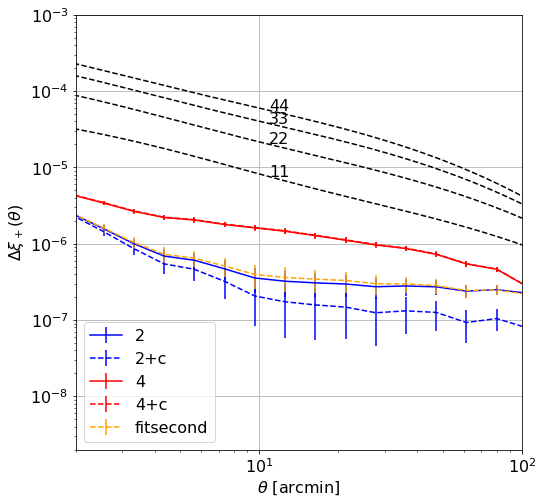

In [38]:

plt.figure(figsize = (8,8))

for i in range(4):
    plt.plot(angle, xip_shear[i], '--', color = 'black')
    plt.text(angle[400], xip_shear[i][400], '{}{}'.format(i+1,i+1))
    

plt.errorbar(second_model.r, second_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())), color = 'blue', label = '2')
plt.errorbar(second_const_model.r, second_const_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())),fmt = '--', color = 'blue', label = '2+c')
plt.errorbar(fourth_model.r, fourth_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())),color = 'red', label = '4')
plt.errorbar(fourth_const_model.r, fourth_const_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())), fmt = '--', color = 'red', label = '4+c')
plt.errorbar(fitsecond_model.r, fitsecond_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())), fmt = '--', color = 'orange', label = 'fitsecond')

# plt.plot(fourth_only_model.r, fourth_only_model.delta_xip, '--', color = 'red', label = '4-2')


plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel(r'$\Delta \xi_+ (\theta)$')

plt.xscale('log')
plt.yscale('log')

plt.xlim(2, 100)
plt.ylim(2e-9, 1e-3)

plt.legend()
plt.grid()
plt.savefig('plots/delta_xip.pdf', dpi = 100)

# Non-PSF star catalog

In [52]:
!python compute_cov.py

1276
1276


In [53]:
theta_min = 1
theta_max = 200

fourth_model_nonpsf = psfmod("four", "data/covariance/covariance_nonpsf.txt", constant_mode = False , correlation_ready = False, correlation_file = "data/correlation/full_correlation_const_allstar_nonpsf.pkl",
                     theta_min = theta_min, theta_max = theta_max, nonpsf = True)
fourth_model_nonpsf.go()



[ 0.03742966 -0.40453726  0.18053972 -0.02337661  0.          0.        ]


In [55]:
print(fourth_model_nonpsf.mean_params)

print(fourth_model_nonpsf.chi2, numerical_p_value(fourth_only_model) , fourth_only_model.p_value)

[ 3.74624846e-02 -4.02111828e-01  1.80707096e-01 -2.00967009e-02
  2.83383079e-10 -1.17518828e-10]
93.99700338382462 0.0 0.0


In [43]:
# with open("data/correlation/full_correlation_const_allstar_nonpsf.pkl", 'wb') as f:
#     pickle.dump([fourth_model_nonpsf.r, fourth_model_nonpsf.gp_corr, fourth_model_nonpsf.pp_corr,  fourth_model_nonpsf.psf_const1, fourth_model_nonpsf.psf_const2, fourth_model_nonpsf.egal_mean ], f)
# #     

In [44]:

fourth_model_nonpsf = psfmod("four", "data/covariance/covariance_nonpsf.txt", constant_mode = False , correlation_ready = True, correlation_file = "data/correlation/full_correlation_const_allstar_nonpsf.pkl",
                     theta_min = theta_min, theta_max = theta_max, nonpsf = True)
fourth_model_nonpsf.go()



[ 0.03742966 -0.40453709  0.18053972 -0.02337632  0.          0.        ]


In [49]:
fitsecond_model_nonpsf = psfmod("second", "data/covariance/covariance_nonpsf.txt", constant_mode = False,
                      correlation_ready = True, correlation_file = "data/correlation/full_correlation_const_allstar_nonpsf.pkl",
                      theta_min = 1, theta_max = 200, fitsecond = True, nonpsf = True)
fitsecond_model_nonpsf.go()

[-0.01142975 -0.46907326  0.          0.          0.          0.        ]


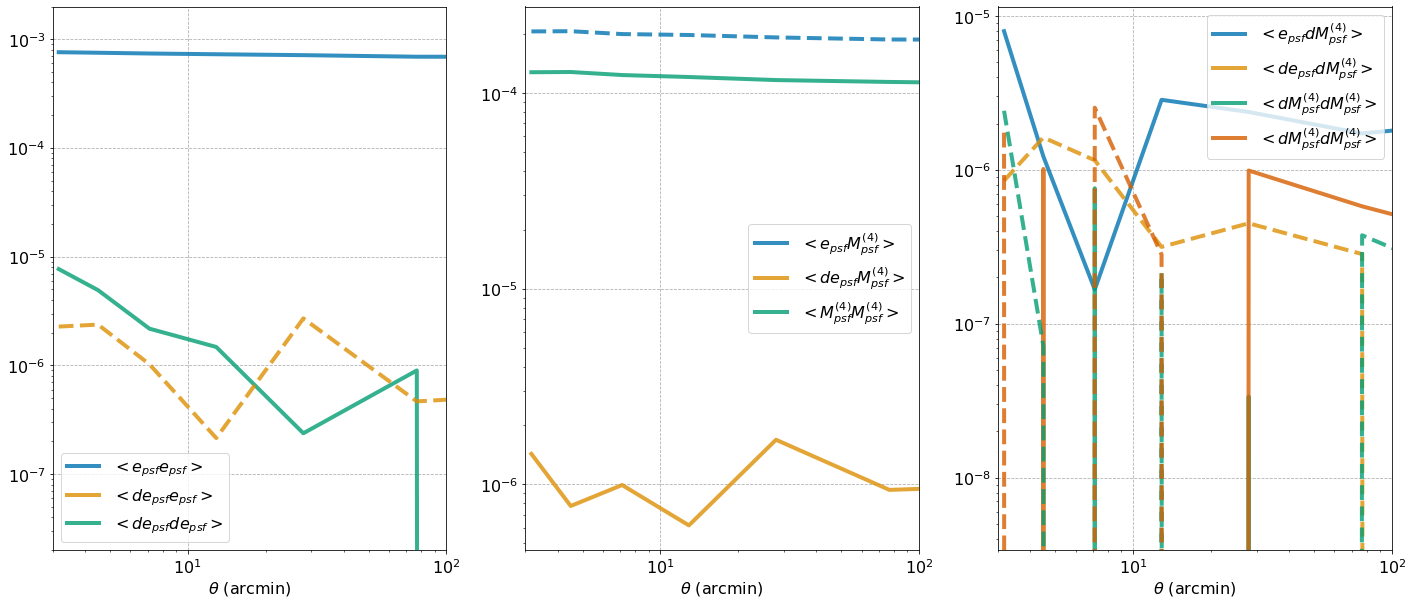

In [47]:
show_pp_corr(fourth_model_nonpsf.r, fourth_model_nonpsf.pp_corr)

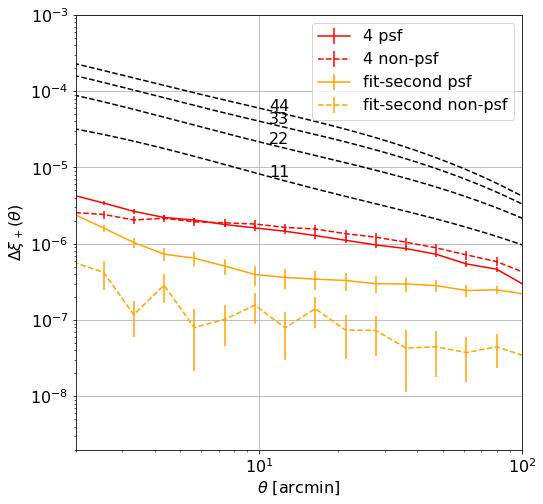

In [51]:
output_dir = "/hildafs/projects/phy200017p/ztq1996/ztq1996/cosmosis/nz/run33-HSCY3-mock/output/hsc-y1-test/shear_xi_plus/"
angle = np.loadtxt(output_dir+'theta.txt')*180/np.pi*60

xip_shear = []
for i in range(4):
    
    xip_shear.append(np.loadtxt(output_dir+'bin_{}_{}.txt'.format(i+1,i+1)))
    

plt.figure(figsize = (8,8))

for i in range(4):
    plt.plot(angle, xip_shear[i], '--', color = 'black')
    plt.text(angle[400], xip_shear[i][400], '{}{}'.format(i+1,i+1))
    

# plt.errorbar(second_model.r, second_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())), color = 'blue', label = '2')
# plt.errorbar(second_const_model.r, second_const_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())),fmt = '--', color = 'blue', label = '2+c')
plt.errorbar(fourth_model.r, fourth_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())),color = 'red', label = '4 psf')
plt.errorbar(fourth_model_nonpsf.r, fourth_model_nonpsf.delta_xip,np.sqrt(np.diag(fourth_model_nonpsf.delta_xip_error())),fmt = '--',color = 'red', label = '4 non-psf')

# plt.errorbar(fourth_const_model.r, fourth_const_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())), fmt = '--', color = 'red', label = '4+c')
plt.errorbar(fitsecond_model.r, fitsecond_model.delta_xip,np.sqrt(np.diag(fourth_model.delta_xip_error())), color = 'orange', label = 'fit-second psf')
plt.errorbar(fitsecond_model_nonpsf.r, fitsecond_model_nonpsf.delta_xip,np.sqrt(np.diag(fitsecond_model_nonpsf.delta_xip_error())), fmt = '--', color = 'orange', label = 'fit-second non-psf')



# plt.plot(fourth_only_model.r, fourth_only_model.delta_xip, '--', color = 'red', label = '4-2')


plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel(r'$\Delta \xi_+ (\theta)$')

plt.xscale('log')
plt.yscale('log')

plt.xlim(2, 100)
plt.ylim(2e-9, 1e-3)

plt.legend()
plt.grid()
